# GR5242 HW01 Problem 4: Early stopping and basic "deep dream"

In this exercise, you will explore some basic methods for preventing overfitting (early stopping and dropout) and explore model introspection by a basic version of Alex Mordvintsev's famous ["deep dream" experiment][deepdream].

## Early stopping and dropout

If we train a model which has lots of parameters (like a neural network) on a relatively simple task, and if your training dataset is relatively small, you are at risk of overfitting to the training dataset. Overfitting can lead to worse performance on data that wasn't used during training, such as test datasets or real new datapoints that your model will be applied to in production.

One way to avoid overfitting is called "early stopping": split your training dataset into two pieces, which we'll call the "training" and "validation" splits. Then, train your model on the training split until the loss on the validation split stops going down. At this point, we have some evidence that the model is starting to memorize the training set, since its performance on the validation set is not improving. This method is not foolproof, but it's easy to use and gives one answer to the question "When should I stop training?" which you would have to answer anyway.

Another way to avoid overfitting is called "dropout": during training, neurons are randomly turned off. This makes it harder for the model to memorize specific inputs. The neural network architecture (defined for you) below will make use of this.

## Deep dream

The goal of "deep dream" is to produce an image which produces strong activity in a unit in your neural network. This will help us understand what that unit is doing, since we can see what kinds of data it responds strongly to. We will perform a very simple version of the original deep dream experiment: find the input image which maximizes the activity of a neuron in a neural network trained to classify the MNIST digits. This will allow us to get some idea of what the network thinks a 0 is, or a 4 is, et cetera.


[deepdream]: https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html


## Setup cells

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
# Load MNIST
(x_train_and_val, y_train_and_val), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and add a channels dimension
x_train_and_val, x_test = x_train_and_val / 255.0, x_test / 255.0
x_train_and_val = x_train_and_val[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print("Full training dataset shape:")
print("x_train_and_val.shape=", x_train_and_val.shape)
print("y_train_and_val.shape=", y_train_and_val.shape)

Full training dataset shape:
x_train_and_val.shape= (60000, 28, 28, 1)
y_train_and_val.shape= (60000,)


## Question 1: Training and validation split

Using NumPy, randomly split the data in to a training and validation split. The training split should include 2/3 of the original data, and the validation split should include the remaining 1/3.

In [ ]:
### QUESTION
# Please fill in the following cells by splitting the arrays
# `x_train_and_val` and `y_train_and_val`. You must assign name
# results using the variable names below.
x_train = ...
y_train = ...
x_val = ...
y_val = ...

In [4]:
### SOLUTION
# What fraction of the training dataset will be kept in the
# train split? The rest (1 - train_proportion) will become
# the validation split.
train_proportion = 2 / 3

# Training and validation split
rg = np.random.default_rng()
train_mask = rg.uniform(size=len(x_train_and_val)) < train_proportion
val_mask = ~train_mask

x_train = x_train_and_val[train_mask]
y_train = y_train_and_val[train_mask]

x_val = x_train_and_val[val_mask]
y_val = y_train_and_val[val_mask]

Here, we define a 3-layer multilayer perceptron with dropout and compile it.

In [5]:
# Define our MLP
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
])

# Set up loss and optimization
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss_fn,
)

## Question 2: Early stopping

Write a for loop which alternates between training the model on 1 pass through the training split (also known as 1 epoch of training) and checking whether we should stop early by measuring the validation loss and seeing if it is still decreasing.

Hints:
 - Remember from a previous exercise that we can use `model.fit(x_train, y_train, epochs=1)` to perform 1 epoch of training
 - The function `model.evaluate` can be used to evaluate the loss on held-out data. Here is a link to the documentation for that function: https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate

In [ ]:
### QUESTION
max_n_epochs = 10

# YOU MAY NEED TO ADD CODE HERE

for epoch in range(max_n_epochs):
    # Learn on another epoch of training data
    # FILL IN HERE

    # Evaluate the loss on the validation split
    # FILL IN HERE

    # Check if the validation loss has decreased,
    # and use `break` to exit the for loop if so.
    # FILL IN HERE
    ...

In [6]:
### SOLUTION
# Training loop with early stopping
# This is an explicit way to write this, but in practice it would be
# better to use keras' EarlyStopping callback. Not sure which one
# is better for a homework? (The question could be flexible enough
# to allow either answer.)
max_n_epochs = 10
prev_epoch_val_loss = np.inf
for epoch in range(max_n_epochs):
    # Learn on another epoch of training data
    model.fit(x_train, y_train, epochs=1)

    # Evaluate on the validation split
    val_loss = model.evaluate(x_val, y_val)
    print(f"Validation: loss={val_loss:0.3f}")

    # Should we stop early?
    if val_loss >= prev_epoch_val_loss:
        print("Stopped at epoch", epoch)
        break

    prev_epoch_val_loss = val_loss

628/628 [==============================] - 1s 2ms/step - loss: 0.1527
Validation: loss=0.153
628/628 [==============================] - 1s 1ms/step - loss: 0.1267
Validation: loss=0.127
628/628 [==============================] - 1s 1ms/step - loss: 0.1186
Validation: loss=0.119
628/628 [==============================] - 1s 1ms/step - loss: 0.1159
Validation: loss=0.116
628/628 [==============================] - 1s 1ms/step - loss: 0.0972
Validation: loss=0.097
628/628 [==============================] - 1s 1ms/step - loss: 0.0951
Validation: loss=0.095
628/628 [==============================] - 1s 1ms/step - loss: 0.0951
Validation: loss=0.095
Stopped at epoch 6


As an extra check, we can look at the loss on the test dataset.

In [7]:
test_loss = model.evaluate(x_test, y_test)
print(f"Test: loss={test_loss:0.3f}")

313/313 [==============================] - 0s 1ms/step - loss: 0.0917
Test: loss=0.092


### Question 3: Test data written answer question

Would it have been good practice to use the test dataset instead of the validation split to perform early stopping above? Why or why not?

(your answer here)

## Question 4: Basic "deep dream"

(4.a) Implement the basic "deep dream"

Our goal in this part of the problem is to find input images which maximally activate the output neuron corresponding to a particular class (for MNIST, that means corresponding to a particular digit). Let's pick the target class `0`.

We'll do this the same way we trained our neural net: start from random images, and use stochastic gradient descent on some cost function to improve the images.

Below, we have included code for randomly initializing the images, and for using the Adam optimizer to minimize a cost function. You are asked to fill in the cost function so that minimizing the cost function leads to maximizing the value of the "0" neuron in the output layer when the neural net is given `dream_images` as input. Make sure to use `dream_images` in your definition of `cost_function`.

In [ ]:
### QUESTION
# "Deep dream"
# Construct random images
n_dream_images = 16
dream_images = tf.Variable(
    np.random.uniform(size=(n_dream_images, 28, 28, 1)).astype(np.float32)
)

def cost_function():
    ### YOUR CODE HERE
    ...

# Optimization loop to have Adam optimize `dream_images`
opt = tf.keras.optimizers.Adam()
for it in range(1000):
    opt.minimize(cost_function, [dream_images]).numpy()

In [10]:
### SOLUTION
# "Deep dream"
# Construct random image
n_dream_images = 16
dream_images = tf.Variable(
    np.random.uniform(size=(n_dream_images, 28, 28, 1)).astype(np.float32)
)

def cost_function():
    logits = model(dream_images)
    dream_objective = logits[:, 0]
    return -dream_objective


opt = tf.keras.optimizers.Adam()
for it in range(1000):
    opt.minimize(cost_function, [dream_images]).numpy()

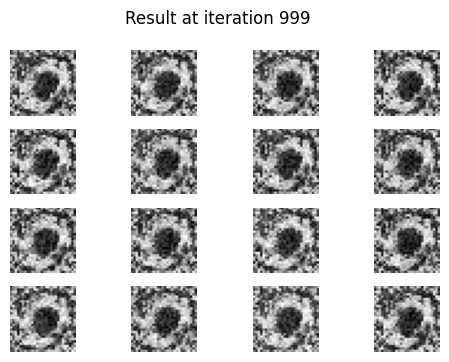

In [11]:
# This is plotting code, which will display the resulting images
fig, axes = plt.subplots(
    ncols=4, nrows=n_dream_images // 4, sharex=True, sharey=True, dpi=100
)
for im, ax in zip(dream_images.numpy(), axes.flat):
    ax.imshow(im[:, :, 0], cmap=plt.cm.gray)
    ax.axis("off")
fig.suptitle(f"Result at iteration {it}")
plt.show()
plt.close(fig)

(4.b) After running the cell above to look at the result, do you have any reactions to what appears? In general, what can this basic version of deep dream tell us about our model?

(your answer here)